In [258]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO, autoguide
from pyro.optim import Adam, ClippedAdam
import torch

In [259]:
df_weather = pd.read_csv('./data/2023_Weather.csv')
df_weather.drop(columns=['Unnamed: 0'], inplace=True)
df_weather.dropna(inplace=True)
df_weather.rename(columns={'Time': 'datetime'}, inplace=True)
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_weather.set_index('datetime', inplace=True)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8759 entries, 2023-01-01 00:00:00 to 2023-12-31 23:00:00
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   acc_precip         8759 non-null   float64
 1   mean_temp          8759 non-null   float64
 2   mean_relative_hum  8759 non-null   float64
 3   mean_wind_speed    8759 non-null   float64
 4   mean_radiation     8759 non-null   float64
dtypes: float64(5)
memory usage: 410.6 KB


In [260]:
# Read and parse
df_acc = pd.read_csv('./data/2022-2024-accident-data.csv', sep=';', dtype=str, encoding='latin1')
df_acc['X'] = df_acc['X_KOORDINAT'].str.replace(',', '.').astype(float)
df_acc['Y'] = df_acc['Y_KOORDINAT'].str.replace(',', '.').astype(float)
df_acc['datetime'] = pd.to_datetime(df_acc['UHELDSDATO'] + ' ' + df_acc['TIME'] + ':00', format='mixed') # %d.%m.%Y %H:%M

In [261]:
# Filter data
cols = ['X', 'Y', 'datetime']

df_acc = df_acc[cols]
df_acc = df_acc[(df_acc['datetime'] > '2023-01-01') & (df_acc['datetime'] < '2024-01-01')]
df_acc.sort_values(by='datetime', inplace=True)
df_acc.set_index('datetime', inplace=True)
df_acc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2071 entries, 2023-01-01 01:00:00 to 2023-12-31 20:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       2071 non-null   float64
 1   Y       2071 non-null   float64
dtypes: float64(2)
memory usage: 48.5 KB


In [262]:
df_acc

,X,Y
datetime,,
2023-01-01 01:00:00,722486.694,6174248.234
2023-01-01 06:00:00,723849.001,6179181.001
2023-01-01 15:00:00,724281.001,6180047.001
2023-01-02 07:00:00,725480.428,6175703.304
2023-01-02 07:00:00,725696.001,6172194.001
...,...,...
2023-12-31 11:00:00,725767.621,6175295.080
2023-12-31 14:00:00,721999.001,6174749.001
2023-12-31 14:00:00,727656.001,6174998.001


In [264]:
# Calculate grid
CELL_SIZE = 500

# Compute origin
minx, miny = df_acc['X'].min(), df_acc['Y'].min()

# Compute bin indices with floor
df_acc['ix'] = np.floor((df_acc['X'] - minx) // CELL_SIZE).astype(int)
df_acc['iy'] = np.floor((df_acc['Y'] - miny) // CELL_SIZE).astype(int)
    
# First, calculate the center coordinates for each cell
df_acc['center_x'] = minx + (df_acc['ix'] + 0.5) * CELL_SIZE
df_acc['center_y'] = miny + (df_acc['iy'] + 0.5) * CELL_SIZE

df_acc['cell_id'] = list(zip(df_acc['center_x'], 
                        df_acc['center_y']))

# Now groupby with the calculated centers
df_acc = df_acc.groupby(['cell_id', 'datetime']).size().rename('acc_count')

In [266]:
unique_cells = df_acc.index.get_level_values('cell_id').unique()
hours  = df_weather.index
idx = pd.MultiIndex.from_product([unique_cells, hours],
                                names=['cell_id', 'datetime'])

df = pd.DataFrame(index=idx)


In [268]:
# put the counts in and turn NaN → 0
df = df.join(df_acc).fillna({'acc_count': 0}).astype({'acc_count': int})

In [255]:
df[df['acc_count'] > 0]

ix    iy  acc_count
cell_id                   datetime                                  
(717514.445, 6177963.565) 2023-08-09 23:00:00   0.0  18.0          1
                          2023-11-11 15:00:00   0.0  18.0          1
(717514.445, 6178963.565) 2023-02-24 22:00:00   0.0  20.0          1
(717514.445, 6179463.565) 2023-01-04 22:00:00   0.0  21.0          1
                          2023-11-04 16:00:00   0.0  21.0          1
...                                             ...   ...        ...
(729014.445, 6172963.565) 2023-08-13 17:00:00  23.0   8.0          1
                          2023-12-09 20:00:00  23.0   8.0          1
(729014.445, 6173463.565) 2023-06-06 16:00:00  23.0   9.0          1
                          2023-10-06 10:00:00  23.0   9.0          1
(729014.445, 6173963.565) 2023-10-06 15:00:00  23.0  10.0          1

[2064 rows x 3 columns]

In [272]:
df

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2697772 entries, ((717514.445, 6177963.565), Timestamp('2023-01-01 00:00:00')) to ((729014.445, 6173963.565), Timestamp('2023-12-31 23:00:00'))
Data columns (total 1 columns):
 #   Column     Dtype
---  ------     -----
 0   acc_count  int64
dtypes: int64(1)
memory usage: 95.7+ MB


In [72]:
df = df_weather.join(df_acc, on='datetime')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9078 entries, 2023-01-01 00:00:00 to 2023-12-31 23:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   acc_precip         9078 non-null   float64
 1   mean_temp          9078 non-null   float64
 2   mean_relative_hum  9078 non-null   float64
 3   mean_wind_speed    9078 non-null   float64
 4   mean_radiation     9078 non-null   float64
 5   X                  2071 non-null   float64
 6   Y                  2071 non-null   float64
dtypes: float64(7)
memory usage: 567.4 KB


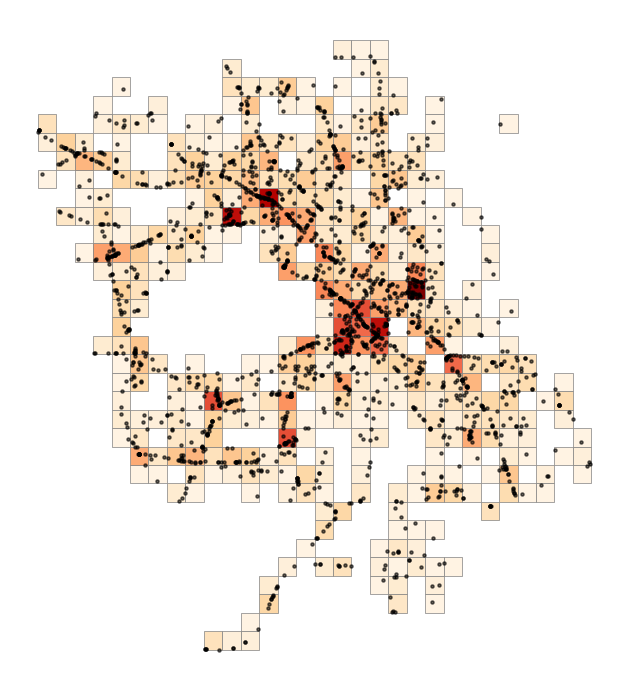

In [75]:
def count_accidents_grid(df_acc, cell_size):
    """
    Given a DataFrame with float columns 'X' and 'Y' (in metres),
    returns a DataFrame of grid‐cell counts plus the origin (minx,miny).
    """
    # Drop na rows
    df2 = df_acc[['X','Y']].copy().dropna()

    # Compute origin
    minx, miny = df2['X'].min(), df2['Y'].min()

    # Compute bin indices with floor
    df2['ix'] = np.floor((df2['X'] - minx) / cell_size).astype(int)
    df2['iy'] = np.floor((df2['Y'] - miny) / cell_size).astype(int)
    
    counts = (
        df2
        .groupby(['ix','iy'])
        .size()
        .reset_index(name='count')
    )
    
    # compute centres
    counts['center_x'] = minx + (counts['ix'] + 0.5) * cell_size
    counts['center_y'] = miny + (counts['iy'] + 0.5) * cell_size

    return counts, minx, miny

def plot_grid_counts(df_acc, counts, minx, miny, cell_size):
    """
    Draws a coloured grid and overlays the accidents.
    """
    vmax = counts['count'].max()
    fig, ax = plt.subplots(figsize=(7,7))

    # draw each occupied cell
    for _, row in counts.iterrows():
        x0 = minx + row['ix'] * cell_size
        y0 = miny + row['iy'] * cell_size
        rect = plt.Rectangle(
            (x0, y0),
            cell_size, cell_size,
            facecolor=plt.cm.OrRd(row['count']/vmax),
            edgecolor='grey', linewidth=0.5
        )
        ax.add_patch(rect)

    # scatter points
    ax.scatter(df_acc['X'], df_acc['Y'], s=5, c='black', alpha=0.6)

    ax.set_aspect('equal')
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

cell_size = 400   # metres
grid, minx, miny = count_accidents_grid(df_acc, cell_size)
plot_grid_counts(df_acc, grid, minx, miny, cell_size)

In [76]:
grid.sort_values(by='count', ascending=False, inplace=True)

In [77]:
grid

,ix,iy,count,center_x,center_y
315,20,19,31,725464.445,6176513.565
149,12,24,27,722264.445,6178513.565
267,18,17,26,724664.445,6175713.565
114,10,23,26,721464.445,6178113.565
220,16,16,24,723864.445,6175313.565
...,...,...,...,...,...
99,9,21,1,721064.445,6177313.565
25,4,15,1,719064.445,6174913.565
24,4,14,1,719064.445,6174513.565
369,23,23,1,726664.445,6178113.565


In [9]:
df_acc

,AAR,UHELDSART,UHELDKOMMUNE,X_KOORDINAT,Y_KOORDINAT,UHELDSDATO,TIME,X,Y
0,2022,Pskduh,København,"721421,168","6178140,391",02-01-2022,18,721421.168,6178140.391
1,2022,Pskduh,København,"724091,001","6175843,001",04-01-2022,19,724091.001,6175843.001
2,2022,Pskduh,København,"721883,001","6179474,001",05-01-2022,15,721883.001,6179474.001
3,2022,Pskduh,København,"727758,001","6175158,001",05-01-2022,22,727758.001,6175158.001
4,2022,Pskduh,København,"721400,001","6179601,001",06-01-2022,7,721400.001,6179601.001
...,...,...,...,...,...,...,...,...,...
6354,2024,Anmsuh,København,"722362,001","6179284,001",10-12-2024,16,722362.001,6179284.001
6355,2024,Exuh,København,"724640,001","6176761,001",23-12-2024,10,724640.001,6176761.001
6356,2024,Exuh,København,"727275,301","6174883,14",31-12-2024,0,727275.301,6174883.140
6357,2024,Anmsuh,København,"721402,001","6181261,001",18-12-2024,8,721402.001,6181261.001


In [41]:
import pyro
import pyro.distributions as dist

# 1) Poisson‐count model
def poisson_model(counts, num_cells):
    # Priors over regression coefficients
    beta0       = pyro.sample("beta0",       dist.Normal(0., 10.))
    beta_precip = pyro.sample("beta_precip", dist.Normal(0., 10.))
    # Latent precipitation for each cell
    precip = pyro.sample(
        "precip", 
        dist.Normal(0., 1.)
            .expand([num_cells])
            .to_event(1)
    )
    with pyro.plate("cells", num_cells):
        # log‐link: λ_i = exp(β0 + β_precip * precip_i)
        rate = torch.exp(beta0 + beta_precip * precip)
        pyro.sample("obs_counts", dist.Poisson(rate), obs=counts)


# 2) Bernoulli‐presence model
def bernoulli_model(presence, num_cells):
    # Priors over regression coefficients
    alpha0       = pyro.sample("alpha0",       dist.Normal(0., 10.))
    alpha_precip = pyro.sample("alpha_precip", dist.Normal(0., 10.))
    # Same latent precipitation
    precip = pyro.sample(
        "precip", 
        dist.Normal(0., 1.)
            .expand([num_cells])
            .to_event(1)
    )
    with pyro.plate("cells", num_cells):
        # logit‐link: logit(p_i) = α0 + α_precip * precip_i
        logits = alpha0 + alpha_precip * precip
        pyro.sample("obs_presence", dist.Bernoulli(logits=logits), obs=presence)

In [42]:
counts   = torch.tensor(grid['count'].values, dtype=torch.float)
presence = (counts > 0).float()
num_cells = counts.size(0)

In [43]:
# Clear any old parameters
pyro.clear_param_store()

# Guide: mean‐field normal over all latent RVs in poisson_model
poisson_guide = autoguide.AutoNormal(poisson_model)

# SVI object
poisson_svi = SVI(model=poisson_model,
                  guide=poisson_guide,
                  optim=Adam({"lr": 0.02}),
                  loss=Trace_ELBO())

# Training loop
num_iters = 2000
for i in range(num_iters):
    loss = poisson_svi.step(counts, num_cells)
    if i % 200 == 0:
        print(f"[Poisson] Iter {i:>4} \tELBO = {-loss:.1f}")


[Poisson] Iter    0 	ELBO = -15216.9
[Poisson] Iter  200 	ELBO = -1934.6
[Poisson] Iter  400 	ELBO = -1888.6
[Poisson] Iter  600 	ELBO = -1856.9
[Poisson] Iter  800 	ELBO = -1837.0
[Poisson] Iter 1000 	ELBO = -1831.1
[Poisson] Iter 1200 	ELBO = -1836.4
[Poisson] Iter 1400 	ELBO = -1845.4
[Poisson] Iter 1600 	ELBO = -1838.8
[Poisson] Iter 1800 	ELBO = -1837.5


In [38]:
poisson_guide.median().items()

dict_items([('beta0', tensor(-0.8050)), ('beta_precip', tensor(0.1260)), ('precip', tensor([0.0264]))])

In [44]:
# After training: get posterior summaries
poisson_posterior = {name: torch.exp(site).item()
                     if name=="beta0" else site.item()
                     for name, site in poisson_guide.median().items()}
print("Poisson posteriors:", poisson_posterior)

RuntimeError: a Tensor with 513 elements cannot be converted to Scalar

In [50]:
poisson_guide.median().items().

dict_values([tensor(2.0542), tensor(-0.9559), tensor([-2.5566, -2.4990, -2.4415, -2.2915, -2.2020, -2.0503, -2.0924, -1.9170,
        -1.8779, -1.8172, -1.9455, -1.8403, -1.8088, -1.8027, -1.7470, -1.7804,
        -1.7196, -1.7436, -1.7423, -1.7040, -1.6505, -1.6415, -1.5825, -1.5087,
        -1.6122, -1.5411, -1.5308, -1.5382, -1.5231, -1.5733, -1.5184, -1.5502,
        -1.5588, -1.5044, -1.5061, -1.3926, -1.4504, -1.3893, -1.4001, -1.4104,
        -1.4232, -1.3492, -1.4015, -1.3027, -1.2729, -1.2652, -1.3705, -1.3304,
        -1.2935, -1.2303, -1.2583, -1.3228, -1.2305, -1.3385, -1.3126, -1.2851,
        -1.2723, -1.2563, -1.2537, -1.2936, -1.2013, -1.2411, -1.1564, -1.1976,
        -1.1983, -1.0982, -1.1141, -1.1747, -1.0723, -1.1699, -1.0632, -1.0964,
        -1.0870, -1.0693, -1.0741, -1.0685, -1.0546, -1.0965, -1.0676, -0.9805,
        -1.0482, -1.1062, -1.0150, -1.0460, -1.0639, -1.0307, -1.0360, -0.9892,
        -1.0388, -1.0036, -1.0003, -1.0178, -0.8921, -0.9105, -0.8814, -0.